In [1]:
import numpy as np
import cupy as cp
import cupyx.scipy.ndimage as ndimage
import h5py
from holotomocupy.holo import G, GT
from holotomocupy.shift import S, ST
from holotomocupy.recon_methods import multiPaganin
from holotomocupy.utils import *
from holotomocupy.proc import remove_outliers
cp.cuda.Device(3).use()

astropy module not found
olefile module not found


<CUDA Device 3>

# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 1024  # object size in each dimension
pad = n//8 # pad for the reconstructed probe
pos_step = 1 # steps in positions
npos = 18*18 # total number of positions
z1c = -17.75e-3 # [m] position of the CA
detector_pixelsize = 3.03751e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
z1 = np.tile(z1c, [npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnifications[0])  # object voxel size

extra=8
# sample size after demagnification
ne = (3072+1024+512+512)//(2048//n)+2*pad
# extra = 16
# ne = 3096+2*pad+2*extra
show = True
path = f'/data/vnikitin/ESRF/ID16A/20240924/SiemensLH/code2um_nfp18x18_01'
path_out = f'/data/vnikitin/ESRF/ID16A/20240924_rec/SiemensLH/code2um_nfp18x18_01'

## Read data

[[[4740547.07801113 -364657.46753932]
  [4740547.07801113  364657.46753932]
  [4862099.5671909  1093972.40261795]
  [5226757.03473022 1093972.40261795]
  [5226757.03473022 1823287.33769659]
  [4740547.07801113 2431049.78359545]
  [4983652.05637067 3403469.69703363]
  [5105204.54555044 4132784.63211226]
  [5105204.54555044 4132784.63211226]
  [4740547.07801113 5105204.54555044]]]
[[[2208. -300.]
  [2209.   54.]
  [2232.  492.]
  [2382.  560.]
  [2384.  907.]
  [2210. 1054.]
  [2277. 1654.]
  [2329. 2025.]
  [2329. 2025.]
  [2211. 2350.]]]


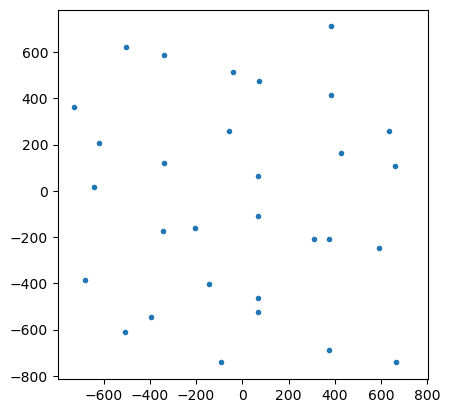

npos=30
-727.5 664.5
-742.0 711.0
2816
95.5 2720.5
49.0 2767.0
2816_128_30_syn_new


In [3]:
shifts_code0 = np.loadtxt(f'/data/vnikitin/ESRF/ID16A/20240924/positions/shifts_code_nfp18x18ordered.txt')[np.newaxis,:,::-1]
shifts_code0 = shifts_code0/voxelsize*(2048)*1e-6
shifts_code0[:,:,1]*=-1

print(shifts_code0[:,-10:])
shifts_code0 = np.load(f'shifts_code_new.npy')
print(shifts_code0[:,-10:])
 
# shifts_code0/=(2048//n)

#centering
shifts_code0[:,:,1]-=(np.amax(shifts_code0[:,:,1])+np.amin(shifts_code0[:,:,1]))/2
shifts_code0[:,:,0]-=(np.amax(shifts_code0[:,:,0])+np.amin(shifts_code0[:,:,0]))/2
shifts_code0 = shifts_code0.reshape(1,int(np.sqrt(npos)),int(np.sqrt(npos)),2)
shifts_code0 = shifts_code0[:,::pos_step,::pos_step,:].reshape(1,npos//pos_step**2,2)

ids = np.where((np.abs(shifts_code0[0,:,0])<ne//2-n//2-pad-extra)*(np.abs(shifts_code0[0,:,1])<ne//2-n//2-pad-extra))[0]#[0:2]
shifts_code0 = shifts_code0[:,ids]


plt.plot(shifts_code0[0,:,0],shifts_code0[0,:,1],'.')
plt.axis('square')
plt.show()

npos = len(ids)
print(f'{npos=}')
print(np.amin(shifts_code0[0,:,0]),np.amax(shifts_code0[0,:,0]))
print(np.amin(shifts_code0[0,:,1]),np.amax(shifts_code0[0,:,1]))
print(ne)
print(np.amin(ne//2-n//2-pad-extra-shifts_code0[0,:,0]),np.amax(ne//2+n//2+pad+extra+shifts_code0[0,:,0]))
print(np.amin(ne//2-n//2-pad-extra-shifts_code0[0,:,1]),np.amax(ne//2+n//2+pad+extra+shifts_code0[0,:,1]))

flg = f'{ne}_{pad}_{npos}_syn_new'
print(flg)

# Process data

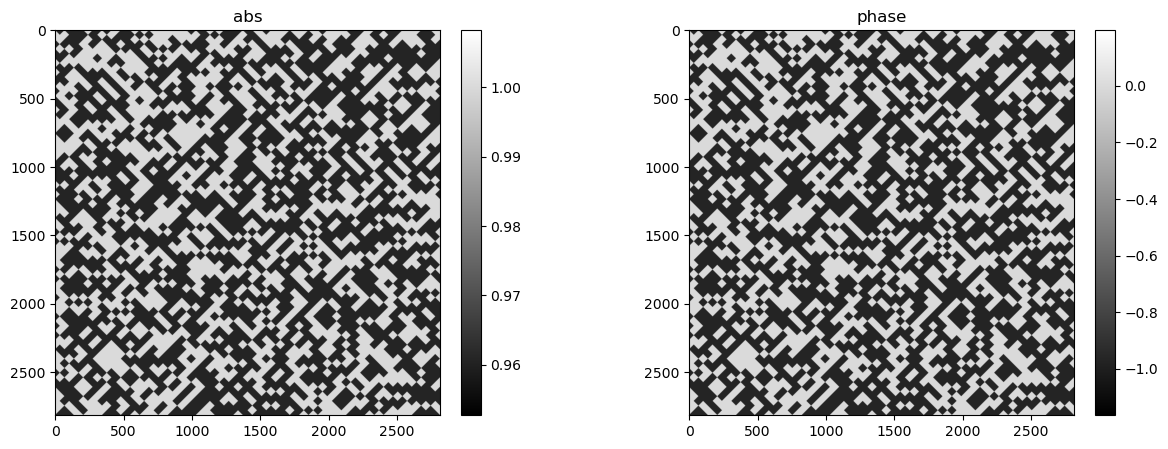

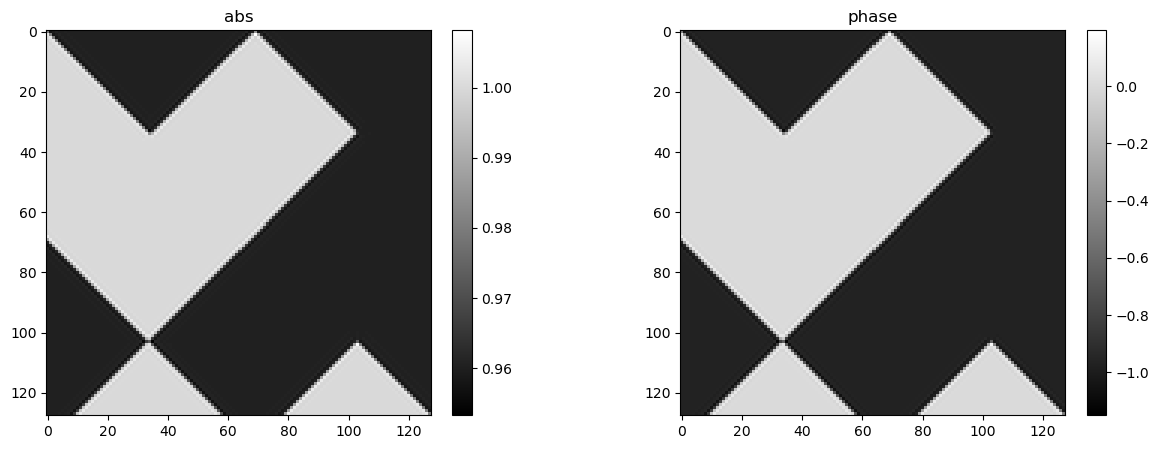

In [4]:
import random
import xraylib
import cupyx.scipy.ndimage as ndimage

ill_feature_size=2e-6
code_thickness=2e-6

random.seed(10)
nill = ne
ill_global = cp.zeros([1,nill,nill],dtype='bool')
for k in  range(ill_global.shape[0]):
    ill0 = cp.zeros([nill*nill],dtype='bool')
    ill_ids = cp.array(random.sample(range(0, nill*nill), int(nill*nill*0.55)))
    ill0[ill_ids] = 1
    ill_global[k] = ill0.reshape(nill,nill)

# form codes for simulations
nill = int(ne*voxelsize//(ill_feature_size*2))*2
ill = cp.zeros([1,nill,nill],dtype='bool')
for k in  range(ill.shape[0]):
    ill0 = ill_global[k]
    ill[k] = ill0[ill0.shape[0]//2-nill//2:ill0.shape[0]//2+(nill)//2,ill0.shape[1]//2-nill//2:ill0.shape[1]//2+(nill)//2]#.reshape(nill,nill)
    
ill = ndimage.zoom(ill,[1,ne/nill,ne/nill],order=0,grid_mode=True,mode='grid-wrap')


delta = 1-xraylib.Refractive_Index_Re('Au',energy,19.3)
beta = xraylib.Refractive_Index_Im('Au',energy,19.3)

thickness = code_thickness/voxelsize # thickness in pixels
Rill = ill*(-delta+1j*beta)*thickness 
Rill=ndimage.rotate(Rill, 45, axes=(2, 1), reshape=False, order=3, mode='reflect',
                   prefilter=True)

v = cp.arange(-ne//2,ne//2)/2/ne
[vx,vy] = np.meshgrid(v,v)
v = cp.exp(-2*(vx**2+vy**2))
fill = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(Rill)))
Rill = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fill*v)))
Rill = Rill.astype('complex64')

code = np.exp(1j * Rill * voxelsize * 2 * np.pi / wavelength).astype('complex64')

# code=code*0+1
mshow_polar(code[0],show)

mshow_polar(code[0,:n//8,:n//8],show)



# Construct operators


In [5]:
def Lop(psi):
    data = cp.zeros([1,npos, n, n], dtype='complex64')
    for i in range(npos):
        psir = psi[:,i].copy()
        # v = cp.ones(ne,dtype='float32')
        # v[:(ne-n)//2] = cp.sin(cp.linspace(0,1,(ne-n)//2)*cp.pi/2)
        # v[-(ne-n)//2:] = cp.cos(cp.linspace(0,1,(ne-n)//2)*cp.pi/2)
        # v = cp.outer(v,v)
        # psir *= v
        psir = G(psir, wavelength, voxelsize, distances[i],'constant')        
        data[:, i] = psir[:,pad:n+pad,pad:n+pad]
    return data

def LTop(data):
    psi = cp.zeros([1, npos, n+2*pad, n+2*pad], dtype='complex64')
    for j in range(npos):
        datar = cp.array(cp.pad(data[:, j],((0,0),(pad,pad),(pad,pad)))).astype('complex64')        
        datar = GT(datar, wavelength, voxelsize, distances[j],'constant')        
        # v = cp.ones(ne,dtype='float32')
        # v[:(ne-n)//2] = cp.sin(cp.linspace(0,1,(ne-n)//2)*cp.pi/2)
        # v[-(ne-n)//2:] = cp.cos(cp.linspace(0,1,(ne-n)//2)*cp.pi/2)
        # v = cp.outer(v,v)        
        # datar *= v
        psi[:,j] += datar    
    return psi

def Sop(psi,ishifts,shifts):
    data = cp.zeros([1, shifts.shape[1], n+2*pad, n+2*pad], dtype='complex64')
    psi = cp.asarray(psi)
    for j in range(shifts.shape[1]):
        psir = Seop(psi,ishifts[:,j])
        shiftsr = cp.array(shifts[:, j])
        psir = S(psir, shiftsr,mode='constant')
        data[:,j] = psir[:,extra:-extra,extra:-extra]
    return data

def STop(data,ishifts,shifts):
    psi = cp.zeros([1, ne, ne], dtype='complex64')
    for j in range(shifts.shape[1]):
        datar = cp.asarray(data[:,j])
        shiftsr = cp.asarray(shifts[:, j])        
        psir = cp.pad(datar,((0,0),(extra,extra),(extra,extra)))     
        psir = ST(psir,shiftsr,mode='constant')
        SeTop(psi,psir,ishifts[:,j])
    return psi

def Seop(psi,ishifts):
    stx = ne//2-ishifts[0,1]-n//2-pad-extra
    endx = stx+n+2*pad+2*extra
    sty = ne//2-ishifts[0,0]-n//2-pad-extra
    endy = sty+n+2*pad+2*extra
    return psi[:,sty:endy,stx:endx]

def SeTop(psi,psir,ishifts):
    stx = ne//2-ishifts[0,1]-n//2-pad-extra
    endx = stx+n+2*pad+2*extra
    sty = ne//2-ishifts[0,0]-n//2-pad-extra
    endy = sty+n+2*pad+2*extra
    psi[:,sty:endy,stx:endx] += psir
    return psi


def Cop(psi,crop):
    res = psi.copy()
    res[...,crop:res.shape[-1]-crop,crop:res.shape[-1]-crop]=0
    return res

def CTop(psi,crop):
    res = psi.copy()
    res[...,crop:res.shape[-1]-crop,crop:res.shape[-1]-crop]=0
    return res

def Cfop(psi,fcrop):
    return psi[:,fcrop:psi.shape[1]-fcrop,fcrop:psi.shape[2]-fcrop]

def CfTop(psi,fcrop):
    return np.pad(psi,((0,0),(fcrop,fcrop),(fcrop,fcrop)))

def Gop(psi,gltype='grad'):
    if gltype=='lap':
        stencil = cp.array([[0, 1, 0],[1, -4, 1], [0, 1, 0]])
        res = psi.copy()
        res[0] = ndimage.convolve(res[0], stencil)
    else:
        res = cp.zeros([2, *psi.shape], dtype='complex64')
        res[0, :, :, :-1] = psi[:, :, 1:]-psi[:, :, :-1]
        res[1, :, :-1, :] = psi[:, 1:, :]-psi[:, :-1, :]
    return res

def GTop(psi,gltype='grad'):
    if gltype=='lap':
        stencil = cp.array([[0, 1, 0],[1, -4, 1], [0, 1, 0]])
        res = psi.copy()
        res[0] = ndimage.convolve(res[0], stencil)
    else:
        res = cp.zeros(psi.shape[1:], dtype='complex64')
        res[:, :, 1:] = psi[0, :, :, 1:]-psi[0, :, :, :-1]
        res[:, :, 0] = psi[0, :, :, 0]
        res[:, 1:, :] += psi[1, :, 1:, :]-psi[1, :, :-1, :]
        res[:, 0, :] += psi[1, :, 0, :]
        res = -res
    return res

# adjoint tests
arr1 = (cp.random.random([1,ne,ne])+1j*cp.random.random([1,ne,ne])).astype('complex64')
shifts_test = cp.array(shifts_code0)
ishifts_test = shifts_test.astype('int32')
shifts_test = shifts_test-ishifts_test

arr2 = Sop(arr1,ishifts_test,shifts_test)
arr3 = STop(arr2,ishifts_test,shifts_test)
print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')

arr1 = (cp.random.random([1,npos,n+2*pad,n+2*pad])+1j*cp.random.random([1,npos,n+2*pad,n+2*pad])).astype('complex64')
arr2 = Lop(arr1)
arr3 = LTop(arr2)
print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')

arr1 = (cp.random.random([1,ne,ne])+1j*cp.random.random([1,ne,ne])).astype('complex64')
arr2 = Gop(arr1)
arr3 = GTop(arr2)
print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')
arr1=arr2=arr3=[]

(32766064+6.220549583435059j)==
(32766066+2.9019198336754926e-05j)
(20874356+1.2819671630859375j)==
(20874358+1.0682433639885858e-05j)
(5287786.5-0.000133514404296875j)==
(5287786.5-9.401610441273078e-06j)


File ‘../data/prb_id16a/prb_abs_2048.tiff’ already there; not retrieving.

File ‘../data/prb_id16a/prb_phase_2048.tiff’ already there; not retrieving.



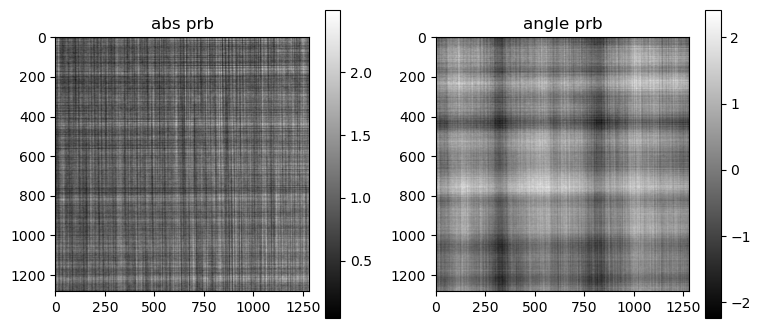

In [6]:
!wget -nc https://g-110014.fd635.8443.data.globus.org/holotomocupy/examples_synthetic/data/prb_id16a/prb_abs_2048.tiff -P ../data/prb_id16a
!wget -nc https://g-110014.fd635.8443.data.globus.org/holotomocupy/examples_synthetic/data/prb_id16a/prb_phase_2048.tiff -P ../data/prb_id16a

import scipy.ndimage as ndimage
prb_abs = dxchange.read_tiff(f'../data/prb_id16a/prb_abs_2048.tiff')[0:1]
prb_phase = dxchange.read_tiff(f'../data/prb_id16a/prb_phase_2048.tiff')[0:1]
prb = prb_abs*np.exp(1j*prb_phase).astype('complex64')

prb = ndimage.zoom(prb,(1,2*n/2048,2*n/2048))
prb = prb[:,n-n//2-pad:n+n//2+pad,n-n//2-pad:n+n//2+pad]


prb /= np.mean(np.abs(prb))
# prb[:]=1

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(prb[0]),cmap='gray')
axs[0].set_title('abs prb')
fig.colorbar(im)
im=axs[1].imshow(np.angle(prb[0]),cmap='gray')
axs[1].set_title('angle prb')
fig.colorbar(im)

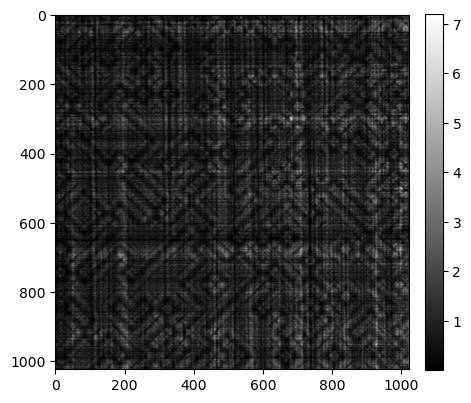

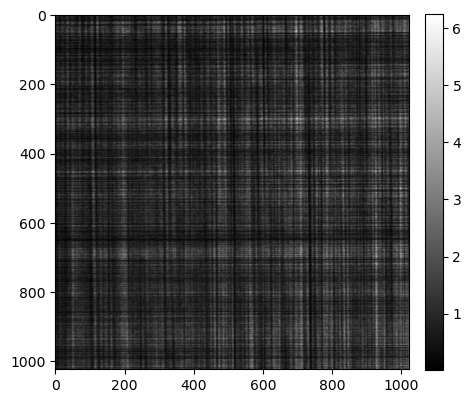

In [7]:
ishifts_test = cp.array(ishifts_test)
shifts_test = cp.array(shifts_test)
code = cp.array(code)
prb = cp.array(prb)
data = cp.abs(Lop(prb*Sop(code,ishifts_test,shifts_test)))**2
ref = cp.abs(Lop(prb*Sop(1+0*code,ishifts_test,shifts_test)))**2
ref = ref[:,0]
rdata = data/ref
mshow(data[0,0],show)
mshow(ref[0],show)


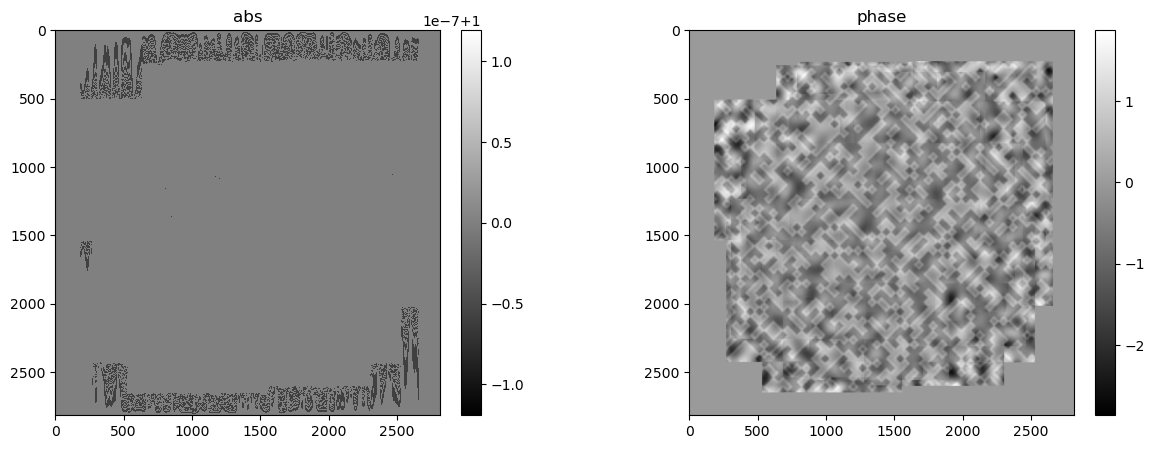

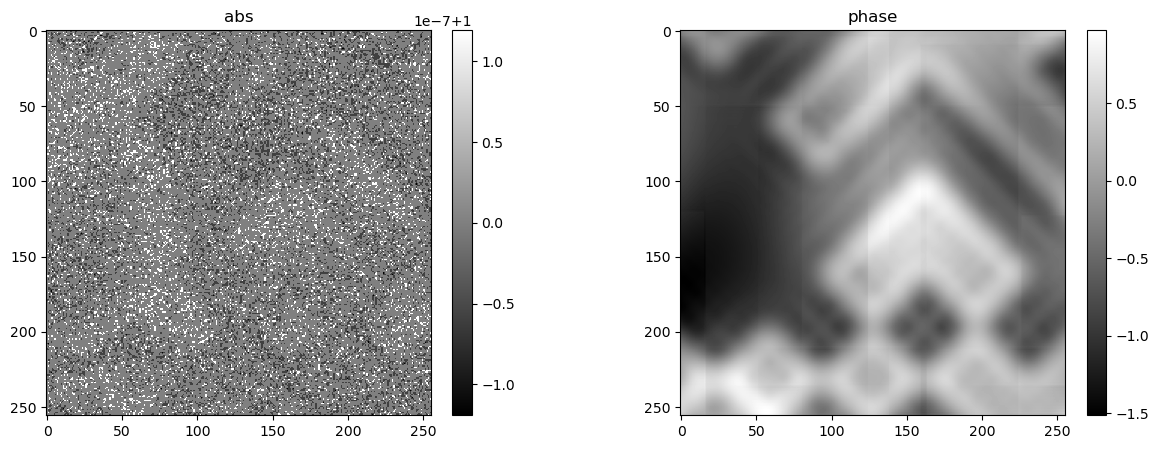

In [8]:
def rec_init(rdata,shifts):
    recMultiPaganin = cp.zeros([1,ne,ne],dtype='float32')
    recMultiPaganinr = cp.zeros([1,ne,ne],dtype='float32')# to compensate for overlap
    for j in range(0,npos):
        rdatar = cp.array(rdata[:,j:j+1])
        r = multiPaganin(rdatar,
                            distances[j:j+1], wavelength, voxelsize,  24.05, 1e-2)    
        rr = r*0+1 # to compensate for overlap
        r = cp.pad(r,((0,0), (ne//2-n//2,ne//2-n//2), (ne//2-n//2,ne//2-n//2)),'constant')   
        rr = cp.pad(rr,((0,0), (ne//2-n//2,ne//2-n//2), (ne//2-n//2,ne//2-n//2)),'constant')   
        shiftsr = cp.array(shifts[:,j])
        recMultiPaganin += ST(r,shiftsr).real
        # mshow(recMultiPaganin[0,j],show)
        recMultiPaganinr += ST(rr,shiftsr).real
        
    # recMultiPaganin = np.sum(recMultiPaganin,axis=1)
    # recMultiPaganinr = np.sum(recMultiPaganinr,axis=1)

    # avoid division by 0
    recMultiPaganinr[np.abs(recMultiPaganinr)<5e-2] = 1

    # compensate for overlap
    recMultiPaganin /= recMultiPaganinr
    v = cp.ones(ne,dtype='float32')
    v[:pad] = np.sin(cp.linspace(0,1,pad)*np.pi/2)
    v[ne-pad:] = np.cos(cp.linspace(0,1,pad)*np.pi/2)
    v = np.outer(v,v)
    recMultiPaganin*=v
    recMultiPaganin = np.exp(1j*recMultiPaganin)

    return recMultiPaganin

rec_paganin = rec_init(rdata,shifts_code0)
mshow_polar(rec_paganin[0],show)
mshow_polar(rec_paganin[0,ne//2-128:ne//2+128,ne//2-128:ne//2+128],show)

## Reconstruction with the CG (Carlsson) with Hessians

$$ H(q,\psi,{{x}})=F(J(q)\cdot S_{{x}}(C_f^*(\psi)+\psi_{fr}))+\lambda_o\|\nabla C(\psi)\|_2^2=\left\||L(M(q,\psi,x))|-d\right\|_2^2+\lambda_o\|\nabla C(\psi)\|_2^2
$$


## Gradients

#### $$\nabla F=2 \left(L^*\left( L(M(q_0,\psi_0,\boldsymbol{x}_0))-\tilde d\right)\right).$$
#### where $$\tilde d = d \frac{L(M(q_0,\psi_0,\boldsymbol{x}_0))}{|L(M(q_0,\psi_0,\boldsymbol{x}_0))|}$$




In [9]:
def gradientF(vars,d):
    (q,psi,x,ix) = (vars['prb'], vars['psi'], vars['shift'],vars['ishift'])
    Lpsi = Lop(Sop(psi,ix,x)*q)
    td = d*(Lpsi/np.abs(Lpsi))
    res = 2*LTop(Lpsi - td)
    return res

##### $$\nabla_{\psi} G|_{(q_0,\psi_0,\boldsymbol{x}_0)}=C_f(S_{\boldsymbol{x}_{0}}^*\left(\overline{J(q_0)}\cdot \nabla F\right))+ \underline{2\lambda \nabla^T (C^T(C(\nabla(\psi))))}$$

##### $$\nabla_{q} G|_{(q_0,\psi_0,\boldsymbol{x}_0)}=J^*\left( \overline{S_{\boldsymbol{x}_{0}}(C_f^*(\psi_0)+\psi_{fr})}\cdot \nabla F\right).$$
##### $$\nabla_{\boldsymbol{x}_0} G|_{(q_0,\psi_0,\boldsymbol{x}_0)}=\textsf{Re}\Big(\big( \Big\langle \overline{q_0}\cdot \nabla F,   C(\mathcal{F}^{-1}(-2\pi i \xi_1 e^{ -2\pi i \boldsymbol{x}_{0,k}\cdot \boldsymbol{\xi}}\hat{\psi_0}))\Big\rangle,\Big\langle \overline{q_0}\cdot \nabla F,C(\mathcal{F}^{-1}(-2\pi i \xi_2 e^{ -2\pi i \boldsymbol{x}_{0,k}\cdot \boldsymbol{\xi}}\hat{\psi_0})) \Big\rangle\big)\Big)_{k=1}^K. $$




In [10]:
def gradientpsi(q,ix,x,gradF):
    return STop(np.conj(q)*gradF,ix,x)

def gradientq(psi,ix,x,gradF):
    res = np.sum(np.conj(Sop(psi,ix,x))*gradF,axis=1)
    return res

def gradientx(psi,q,ix,x,gradF):
    gradx = cp.zeros([1,npos,2],dtype='float32')    
    xi1 = cp.fft.fftfreq(2*(n+2*pad+2*extra)).astype('float32')
    [xi2, xi1] = cp.meshgrid(xi1, xi1)
    
    for j in range(npos):        
        psir = Seop(psi,ix[:,j])        
        psir = cp.pad(psir, ((0, 0), (n//2+pad+extra, n//2+pad+extra), (n//2+pad+extra, n//2+pad+extra)),'constant')
        xj = cp.array(x[:,j,:,np.newaxis,np.newaxis])
        pp = cp.exp(-2*cp.pi*1j*(xi1*xj[:, 0]+xi2*xj[:, 1]))      
        t = cp.fft.ifft2(pp*xi1*cp.fft.fft2(psir))
        nee = t.shape[-1]
        t = t[:,nee//2-n//2-pad:nee//2+n//2+pad,nee//2-n//2-pad:nee//2+n//2+pad]
        gradx[:,j,0] = -2*np.pi*imdot(gradF[:,j],q*t,axis=(1,2))    
    
    for j in range(npos):        
        psir = Seop(psi,ix[:,j])
        psir = cp.pad(psir, ((0, 0), (n//2+pad+extra, n//2+pad+extra), (n//2+pad+extra, n//2+pad+extra)),'constant')
        xj = cp.array(x[:,j,:,np.newaxis,np.newaxis])
        pp = cp.exp(-2*cp.pi*1j*(xi1*xj[:, 0]+xi2*xj[:, 1]))                            
        t = cp.fft.ifft2(pp*xi2*cp.fft.fft2(psir))
        nee = t.shape[-1]
        t = t[:,nee//2-n//2-pad:nee//2+n//2+pad,nee//2-n//2-pad:nee//2+n//2+pad]
        gradx[:,j,1] = -2*np.pi*imdot(gradF[:,j],q*t,axis=(1,2))    

    return gradx

    
def gradients(vars,d,gradF):
    (q,psi,x,rho,ix) = (vars['prb'], vars['psi'], vars['shift'],vars['rho'],vars['ishift'])
    grads = {}
    
    grads['psi'] = rho[0]*gradientpsi(q,ix,x,gradF)
    grads['prb'] = rho[1]*gradientq(psi,ix,x,gradF)
    grads['shift'] = rho[2]*gradientx(psi,q,ix,x,gradF)
    return grads



##### $$\frac{1}{2}\mathcal{H}|_{x_0}(y,z)= \left\langle \mathbf{1}-d_{0}, \mathsf{Re}({L(y)}\overline{L(z)})\right\rangle+\left\langle d_{0},(\mathsf{Re} (\overline{l_0}\cdot L(y)))\cdot (\mathsf{Re} (\overline{l_0}\cdot L(z))) \right\rangle$$
##### $$l_0=L(x_0)/|L(x_0)|$$
##### $$d_0=d/|L(x_0)|$$


In [11]:
def hessianF(hpsi,hpsi1,hpsi2,data):
    Lpsi = Lop(hpsi)        
    Lpsi1 = Lop(hpsi1)
    Lpsi2 = Lop(hpsi2)    
    l0 = Lpsi/np.abs(Lpsi)
    d0 = data/np.abs(Lpsi)
    v1 = np.sum((1-d0)*reprod(Lpsi1,Lpsi2))
    v2 = np.sum(d0*reprod(l0,Lpsi1)*reprod(l0,Lpsi2))  
    return 2*(v1+v2)

##### $D T_\psi|_{{{z}_0}}(\Delta {z})=-2\pi iC\Big(\mathcal{F}^{-1}\big({\Delta z \cdot \xi}) e^{-2\pi i  {z}_0\cdot {\xi}}\hat{\psi}({\xi})\big)\Big)=-2\pi i C\Big(\mathcal{F}^{-1}\big((\Delta z_1 {\xi_1}+\Delta z_2 {\xi_2}) e^{-2\pi i  {z}_0\cdot {\xi}}\hat{\psi}({\xi})\big)\Big)$
##### $ D^2{T_\psi}|_{{{z}_0}}(\Delta{z},\Delta{w})=-4\pi^2C(\mathcal{F}^{-1}((\Delta{z}\cdot\xi)(\Delta{w}\cdot\xi)e^{-2\pi i  {z}_0\cdot {\xi}}\hat{\psi}))$
##### $=-4\pi^2C(\mathcal{F}^{-1}((\Delta{z_1}\Delta{w_1}\xi_1^2 + (\Delta{z_1}\Delta{w_2}+\Delta{z_2}\Delta{w_1})\xi_1\xi_2+\Delta{z_2}\Delta{w_2}\xi_2^2)\hat{\psi}))$

In [12]:
def DT(psi,ix,x,dx):
    res = cp.zeros([1,npos,n+2*pad,n+2*pad],dtype='complex64')
    xi1 = cp.fft.fftfreq(2*(n+2*pad+2*extra)).astype('float32')
    [xi2, xi1] = cp.meshgrid(xi1, xi1)
    for j in range(npos):
        psir = Seop(psi,ix[:,j])
        psir = cp.pad(psir, ((0, 0), (n//2+pad+extra, n//2+pad+extra), (n//2+pad+extra, n//2+pad+extra)),'constant')
        xj = cp.array(x[:,j,:,np.newaxis,np.newaxis])
        dxj = cp.array(dx[:,j,:,np.newaxis,np.newaxis])

        pp = cp.exp(-2*cp.pi*1j*(xi1*xj[:, 0]+xi2*xj[:, 1]))    
        xiall = xi1*dxj[:,0]+xi2*dxj[:,1]

        psir = cp.fft.ifft2(pp*xiall*cp.fft.fft2(psir))   
        nee = psir.shape[-1]
        psir = psir[:,nee//2-n//2-pad:nee//2+n//2+pad,nee//2-n//2-pad:nee//2+n//2+pad]
        res[:,j] = -2*np.pi*1j*psir
    return res

def D2T(psi,ix,x,dx1,dx2):
    res = cp.zeros([1,npos,n+2*pad,n+2*pad],dtype='complex64')
    xi1 = cp.fft.fftfreq(2*(n+2*pad+2*extra)).astype('float32')
    [xi2, xi1] = cp.meshgrid(xi1, xi1)
    for j in range(npos):
        psir = Seop(psi,ix[:,j])
        psir = cp.pad(psir, ((0, 0), (n//2+pad+extra, n//2+pad+extra), (n//2+pad+extra, n//2+pad+extra)),'constant')
        xj = cp.array(x[:,j,:,np.newaxis,np.newaxis])
        dx1j = cp.array(dx1[:,j,:,np.newaxis,np.newaxis])
        dx2j = cp.array(dx2[:,j,:,np.newaxis,np.newaxis])

        pp = cp.exp(-2*cp.pi*1j*(xi1*xj[:, 0]+xi2*xj[:, 1]))    
        xiall = xi1**2*dx1j[:,0]*dx2j[:,0]+ \
                xi1*xi2*(dx1j[:,0]*dx2j[:,1]+dx1j[:,1]*dx2j[:,0])+ \
                xi2**2*dx1j[:,1]*dx2j[:,1]

        psir = cp.fft.ifft2(pp*xiall*cp.fft.fft2(psir))   
        nee = psir.shape[-1]
        psir = psir[:,nee//2-n//2-pad:nee//2+n//2+pad,nee//2-n//2-pad:nee//2+n//2+pad]
        res[:,j] = -4*np.pi**2*psir
    return res

#### $$ DM|_{(q_0,\psi_0,\boldsymbol{x})}(\Delta q, \Delta \psi,\Delta\boldsymbol{x})=$$
#### $$ \Big(\Delta q\cdot T_{\psi_0}({\boldsymbol{x}_{0,k}})+ q_0\cdot \big(T_{\Delta \psi}({\boldsymbol{x}_{0,k}})+  DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}_k)\big) \Big)_{k=1}^K=$$
#### $$ J(\Delta q)\cdot S_{\boldsymbol{x}_{0,k}}(\psi_0)+ J(q_0)\cdot S_{\boldsymbol{x}_{0}}{(\Delta \psi)}+  \Big(q_0\cdot DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}_k) \Big)_{k=1}^K$$


In [13]:
def DM(psi,q,ix,x,dpsi,dq,dx):
    res = dq*Sop(psi,ix,x)+q*(Sop(dpsi,ix,x)+DT(psi,ix,x,dx))   
    return res

##### $$ D^2M|_{(q_0,\psi_0,\boldsymbol{x})}\big((\Delta q^{(1)}, \Delta \psi^{(1)},\Delta\boldsymbol{x}^{(1)}),(\Delta q^{(2)}, \Delta \psi^{(2)},\Delta\boldsymbol{x}^{(2)})\big)= $$
##### $$\Big( q_0\cdot DT_{\Delta\psi^{(1)}}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(2)})+q_0\cdot DT_{\Delta\psi^{(2)}}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(1)})+ q_0\cdot D^2{T_\psi}|_{{\boldsymbol{x}_0}}(\Delta\boldsymbol{x}^{(1)},\Delta\boldsymbol{x}^{(2)})+$$
##### $$\Delta q^{(1)}\cdot T_{\Delta \psi^{(2)}}({\boldsymbol{x}_{0,k}})+\Delta q^{(2)}\cdot T_{\Delta \psi^{(1)}}({\boldsymbol{x}_{0,k}})+ $$
##### $$\Delta q^{(1)}\cdot DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(2)})+\Delta q^{(2)}\cdot DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(1)})\Big)_{k=1}^K.$$


In [14]:
def D2M(psi,q,ix,x,dpsi1,dq1,dx1,dpsi2,dq2,dx2):    
    res =  q*DT(dpsi1,ix,x,dx2) + q*DT(dpsi2,ix,x,dx1) + q*D2T(psi,ix,x,dx1,dx2)  
    res += dq1*Sop(dpsi2,ix,x) + dq2*Sop(dpsi1,ix,x) 
    res += dq1*DT(psi,ix,x,dx2) + dq2*DT(psi,ix,x,dx1)
    return res

##### $$\mathcal{H}^G|_{ (q_0,\psi_0,\boldsymbol{x}_0)}\Big((\Delta q^{(1)},\Delta \psi^{(1)},\Delta \boldsymbol{x}^{(1)}),(\Delta q^{(2)},\Delta \psi^{(2)},\Delta \boldsymbol{x}^{(2)})\Big)=$$
##### $$\Big\langle \nabla F|_{M(q_0,\psi_0,\boldsymbol{x}_0)}, D^2M|_{(q_0,C_f^*(\psi_0),\boldsymbol{x}_0)}\Big((\Delta q^{(1)},C_f^*(\Delta \psi^{(1)}),\Delta \boldsymbol{x}^{(1)}),(\Delta q^{(2)},C_f^*(\Delta \psi^{(2)}),\Delta \boldsymbol{x}^{(2)})\Big)\Big\rangle +$$
##### $$\mathcal{H}^F|_{M(q_0,\psi_0,\boldsymbol{x}_0)}\Big(DM|_{(q_0,C_f^*(\psi_0),\boldsymbol{x}_0)}(\Delta q^{(1)},C_f^*(\Delta \psi^{(1)}),\Delta \boldsymbol{x}^{(1)}),DM|_{(q_0,\psi_0,\boldsymbol{x}_0)}(\Delta q^{(2)},C_f^*(\Delta \psi^{(2)}),\Delta \boldsymbol{x}^{(2)})\Big)+$$
##### $$+\underline{2\lambda \textsf{Re}\langle C(\nabla  (\Delta \psi^{(1)})),C(\nabla ( \Delta \psi^{(2)}))\rangle}$$

### Updates:

\begin{equation}
               \alpha_j=\frac{\mathsf{Re}\langle \nabla F|_{x_j},s_j\rangle}{H|_{x_j}( {s_j},s_j)}
             \end{equation}

\begin{equation}
                \beta_j=\frac{H(\nabla F|_{x_j},s_j)}{H|_{x_j}( {s_j},s_j)}.
\end{equation}

### Scaling variables:

\begin{equation}
\begin{aligned}
\tilde{\beta}_j=\frac{H^{\tilde{F}}|_{\tilde{x}_j} (\nabla \tilde{F}|_{\tilde{x}_j},\tilde{\eta}_j)}{H^{\tilde{F}}|_{\tilde{x}_j} (\tilde{\eta}_j,\tilde{\eta}_j)}=\frac{H^{F}|_{x_j} (\rho\nabla \tilde{F}|_{\tilde{x}_j},\rho\tilde{\eta}_j)}{H^{F}|_{x_j} (\rho\tilde{\eta}_j,\rho\tilde{\eta}_j)}=\frac{H^{F}|_{x_j} (\rho^2\nabla F|_{x_j},\rho\tilde{\eta}_j)}{H^{F}|_{x_j} (\rho\tilde{\eta}_j,\rho\tilde{\eta}_j)}
\end{aligned}
\end{equation}

\begin{equation}
\begin{aligned}
\tilde{\alpha}_j=\frac{\langle\nabla \tilde{F}|_{\tilde{x}_j},\tilde{\eta}_j\rangle}{H^{\tilde{F}}|_{\tilde{x}_j} (\tilde{\eta}_j,\tilde{\eta}_j)}=\frac{\langle \rho\nabla F|_{x_j},\tilde{\eta}_j\rangle}{H^{F}|_{x_j} (\rho\tilde{\eta}_j,\rho\tilde{\eta}_j)}
\end{aligned}
\end{equation}

\begin{equation}
    \begin{aligned}
        \tilde{\eta}_{j+1} = -\nabla \tilde{F}|_{\tilde{x}_j}+\tilde{\beta}_j\tilde{\eta}_j=-\rho\nabla F|_{x_j}+\tilde{\beta}_j\tilde{\eta}_j,\quad \text{with } \tilde{\eta}_0=-\rho\nabla F|_{x_0}
    \end{aligned}
\end{equation}

\begin{equation}
    \begin{aligned}
        \tilde{x}_{j+1} = \tilde{x}_{j}+\tilde{\alpha}_j\tilde{\eta}_{j+1}
    \end{aligned}
\end{equation}

Multiplying both sides by $\rho$,

\begin{equation}
    \begin{aligned}
        x_{j+1} = x_j+\rho\tilde{\alpha}_j\tilde{\eta}_{j+1}
    \end{aligned}
\end{equation}

In [15]:
def calc_beta(vars,grads,etas,d,gradF):
    (q,psi,x,rho,ix) = (vars['prb'], vars['psi'], vars['shift'],vars['rho'],vars['ishift'])    
    (dpsi1,dq1,dx1) = (grads['psi']*rho[0], grads['prb']*rho[1], grads['shift']*rho[2])
    (dpsi2,dq2,dx2) = (etas['psi']*rho[0], etas['prb']*rho[1], etas['shift']*rho[2])
    
    # beta = top/bottom
    top = 0
    bottom = 0

    
    # 2. frame psi and dpsi    
    d2m1 = D2M(psi,q,ix,x,dpsi1,dq1,dx1,dpsi2,dq2,dx2)
    top += redot(gradF,d2m1)        
    d2m1 = []

    d2m2 = D2M(psi,q,ix,x,dpsi2,dq2,dx2,dpsi2,dq2,dx2)
    bottom += redot(gradF,d2m2)    
    d2m2=[]

    # 3. calculate DM, D2M
    dm1 = DM(psi,q,ix,x,dpsi1,dq1,dx1)
    dm2 = DM(psi,q,ix,x,dpsi2,dq2,dx2)
        
    # 4. finalize computation by the formula
    sq = Sop(psi,ix,x)*q
    top += hessianF(sq, dm1, dm2,d)            
    bottom += hessianF(sq, dm2, dm2,d)
    
    return top/bottom

def calc_alpha(vars,grads,etas,d,gradF):    
    (q,psi,x,rho,ix) = (vars['prb'], vars['psi'], vars['shift'],vars['rho'],vars['ishift'])   
    (dpsi1,dq1,dx1) = (grads['psi'], grads['prb'], grads['shift'])
    (dpsi2,dq2,dx2) = (etas['psi'], etas['prb'], etas['shift']) 

    # beta = top/bottom
    top = 0
    bottom = 0
    
    # 1. top part, doesn't include frame and srho scaling
    top = -redot(dpsi1,dpsi2)-redot(dq1,dq2)-redot(dx1,dx2)
    
    # 2. scale variable fo the hessian
    (dpsi2,dq2,dx2) = (etas['psi']*rho[0], etas['prb']*rho[1], etas['shift']*rho[2])

    # 3. regularization term
    
    # 4. frame psi and dpsi
    d2m2 = D2M(psi,q,ix,x,dpsi2,dq2,dx2,dpsi2,dq2,dx2)
    bottom += redot(gradF,d2m2)
    d2m2 = []

    # 5. calculate DM, D2M
    dm2 = DM(psi,q,ix,x,dpsi2,dq2,dx2)    

    # 6. finalize computation by the formula
    sq = Sop(psi,ix,x)*q    
    
    bottom += hessianF(sq, dm2, dm2,d)
    
    return top/bottom, top, bottom

## debug functions

In [ ]:
def plot_debug2(vars,etas,top,bottom,alpha,data):
    '''Check the minimization functional behaviour'''

    if show==False:
        return
    (q,psi,x,rho,ix) = (vars['prb'], vars['psi'], vars['shift'],vars['rho'],vars['ishift'])
    (dpsi2,dq2,dx2) = (etas['psi'],etas['prb'],etas['shift'])
    npp = 3
    errt = cp.zeros(npp*2)
    errt2 = cp.zeros(npp*2)
    for k in range(0,npp*2):
        psit = psi+(alpha*k/(npp-1))*rho[0]*dpsi2
        qt = q+(alpha*k/(npp-1))*rho[1]*dq2
        xt = x+(alpha*k/(npp-1))*rho[2]*dx2

        fpsit = np.abs(Lop(Sop(psit,ix,xt)*qt))-data
        
        errt[k] = np.sum(np.linalg.norm(fpsit,axis=(2,3))**2)
        
    t = alpha*(cp.arange(2*npp))/(npp-1)
    fpsi = np.abs(Lop(Sop(psi,ix,x)*q))-data
    errt2 = np.sum(np.linalg.norm(fpsi,axis=(2,3))**2)
    errt2 = errt2 -top*t+0.5*bottom*t**2
    
    plt.plot(alpha.get()*cp.arange(2*npp).get()/(npp-1),errt.get(),'.')
    plt.plot(alpha.get()*cp.arange(2*npp).get()/(npp-1),errt2.get(),'.')
    plt.show()

def plot_debug3(shifts,shifts_init):
    '''Current errors in shifts'''

    if show==False:
        return
    plt.plot(shifts_init[0,:,0].get()-(shifts[0,:,0].get()),'r.')
    plt.plot(shifts_init[0,:,1].get()-(shifts[0,:,1].get()),'b.')
    plt.show()

def vis_debug(vars,i):
    '''Visualization and data saving'''

    psi = vars['psi']
    mshow_polar(psi[0],show)
    mshow_polar(psi[0,ne//2-n//8:ne//2+n//8,ne//2+n//4:ne//2+n//2],show)
    mshow_polar(vars['prb'][0],show)
    dxchange.write_tiff(np.angle(psi).get(),f'{path_out}_{flg}/crec_psi_angle/{i:03}',overwrite=True)
    dxchange.write_tiff(np.abs(psi).get(),f'{path_out}_{flg}/crec_psi_abs/{i:03}',overwrite=True)
    dxchange.write_tiff(np.angle(vars['prb']).get(),f'{path_out}_{flg}/crec_prb_angle/{i:03}',overwrite=True)
    dxchange.write_tiff(np.abs(vars['prb']).get(),f'{path_out}_{flg}/crec_prb_abs/{i:03}',overwrite=True)
    np.save(f'{path_out}_{flg}/crec_shift_{i:03}',vars['shift'])
    np.save(f'{path_out}_{flg}/crec_ishift_{i:03}',vars['ishift'])
    
def err_debug(vars, grads, data):    
    '''Print error'''    
    (q,psi,x,rho,ix) = (vars['prb'], vars['psi'], vars['shift'],vars['rho'],vars['ishift'])
    fpsi = np.abs(Lop(Sop(psi,ix,x)*q))-data
    err = np.sum(np.linalg.norm(fpsi,axis=(2,3))**2)
    
    print(f'gradient norms (psi, prb, shift): {np.linalg.norm(grads['psi']):.2f}, {np.linalg.norm(grads['prb']):.2f}, {np.linalg.norm(grads['shift']):.2f}')                        
    return err

# Main CG loop (fifth rule)

In [17]:
def cg_holo(data, vars, pars):
    
    # work with sqrt of data
    data = np.sqrt(data)    
    
    erra = cp.zeros(pars['niter'])
    alphaa = cp.zeros(pars['niter'])    
    shifts_init = vars['shift'].copy()

    for i in range(pars['niter']):    
        
        # if i==128:
        #     vars['crop'][0]=pad//2# = np.array([pad//2,ne//2-n//2-pad//2])        

        gradF = gradientF(vars,data)        
        grads = gradients(vars,data,gradF)
    
        if i==0:# or i==512:
            etas = {}
            etas['psi'] = -grads['psi']
            etas['prb'] = -grads['prb']
            etas['shift'] = -grads['shift']
        else:      
            beta = calc_beta(vars, grads, etas, data, gradF)
            etas['psi'] = -grads['psi'] + beta*etas['psi']
            etas['prb'] = -grads['prb'] + beta*etas['prb']
            etas['shift'] = -grads['shift'] + beta*etas['shift']

        alpha,top,bottom = calc_alpha(vars, grads, etas, data, gradF) 
        if i % pars['vis_step'] == 0 and pars['vis_step'] != -1:
            plot_debug2(vars,etas,top,bottom,alpha,data)

        vars['psi'] += vars['rho'][0]*alpha*etas['psi']
        vars['prb'] += vars['rho'][1]*alpha*etas['prb']
        vars['shift'] += vars['rho'][2]*alpha*etas['shift']
        
        if i % pars['err_step'] == 0 and pars['err_step'] != -1:
            err = err_debug(vars, grads, data)    
            print(f'{i}) {alpha=:.5f}, {vars['rho']} {err=:1.5e}',flush=True)
            erra[i] = err
            alphaa[i] = alpha

        if i % pars['vis_step'] == 0 and pars['vis_step'] != -1:
            vis_debug(vars, i)
            if vars['rho'][2]>0:
                plot_debug3(vars['shift'],shifts_init)                         
            
    return vars,erra,alphaa

vars = {}
vars['psi'] = rec_paganin
vars['prb'] = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')  
shifts_test = cp.array(shifts_code0)
ishifts_test = shifts_test.astype('int32')
shifts_test = shifts_test-ishifts_test


vars['ishift'] = cp.array(shifts_code0).astype('int32') 
vars['shift'] = cp.array(shifts_code0)-cp.array(shifts_code0).astype('int32') 

#error
vars['shift']+=2*(cp.random.random([1,npos,2])-0.5).astype('float32')

vars['rho'] = [1,1,0.1]
data_rec = cp.array(data)
pars = {'niter': 10000, 'err_step': 32, 'vis_step': 128}

%load_ext line_profiler
%lprun -f cg_holo cg_holo(data_rec, vars, pars)   

NameError: name 'w' is not defined

# use only the middle part to adjust the probe

In [ ]:
# iter = 32
# psi_abs = dxchange.read_tiff(f'{path_out}_{flg}/crec_psi_abs/{iter:03}.tiff')
# psi_angle = dxchange.read_tiff(f'{path_out}_{flg}/crec_psi_angle/{iter:03}.tiff')
# psi = psi_abs*np.exp(1j*psi_angle)

# prb_abs = dxchange.read_tiff(f'{path_out}_{flg}/crec_prb_abs/{iter:03}.tiff')
# prb_angle = dxchange.read_tiff(f'{path_out}_{flg}/crec_prb_angle/{iter:03}.tiff')
# prb = prb_abs*np.exp(1j*prb_angle)

# ishifts_test = np.load(f'{path_out}_{flg}/crec_ishift_{iter:03}.npy')
# shifts_test = np.load(f'{path_out}_{flg}/crec_shift_{iter:03}.npy')
# shifts_code0 = ishifts_test+shifts_test

# nee = (2048+512+256)//(2048//n)+2*pad
# ids = np.where((np.abs(shifts_code0[0,:,0])<nee//2-n//2-pad-extra)*(np.abs(shifts_code0[0,:,1])<nee//2-n//2-pad-extra))[0]#[0:2]
# data_new = data[:,ids]
# shifts_code0 = shifts_code0[:,ids]
# ishifts_test = ishifts_test[:,ids]
# shifts_test = shifts_test[:,ids]


# plt.plot(shifts_code0[0,:,0],shifts_code0[0,:,1],'.')
# plt.axis('square')
# plt.show()

# npos = len(ids)
# print(f'{npos=}')
# print(np.amin(shifts_code0[0,:,0]),np.amax(shifts_code0[0,:,0]))
# print(np.amin(shifts_code0[0,:,1]),np.amax(shifts_code0[0,:,1]))
# print(ne)
# print(np.amin(ne//2-n//2-pad-extra-shifts_code0[0,:,0]),np.amax(ne//2+n//2+pad+extra+shifts_code0[0,:,0]))
# print(np.amin(ne//2-n//2-pad-extra-shifts_code0[0,:,1]),np.amax(ne//2+n//2+pad+extra+shifts_code0[0,:,1]))

# flg = f'{ne}_{pad}_{npos}'
# print(flg)

# vars['crop'] = [0,0]
# vars['psi'] = cp.array(psi)
# vars['psifr'] = cp.ones([ne,ne],dtype='complex64')
# vars['psifr'][vars['crop'][1]:ne-vars['crop'][1],vars['crop'][1]:ne-vars['crop'][1]]=0
# vars['prb'] = cp.array(prb)


# vars['ishift'] = cp.array(ishifts_test)
# vars['shift'] = cp.array(shifts_test)
# vars['rho'] = [0,1,0.1]
# vars['lam'] = 0
# data_rec = cp.array(data_new)
# pars = {'niter': 65, 'err_step': 16, 'vis_step': 32}

# %load_ext line_profiler
# %lprun -f cg_holo cg_holo(data_rec, vars, pars)   

In [ ]:
# import scipy as sp

# def _downsample(data, binning):
#     res = data.copy()
#     for k in range(binning):
#         res = 0.5*(res[..., ::2,:]+res[..., 1::2,:])
#         res = 0.5*(res[..., :, ::2]+res[..., :, 1::2])
#     return res

# def _fftupsample(f, dims):
#     paddim = np.zeros([np.ndim(f), 2], dtype='int32')
#     dims = np.asarray(dims).astype('int32')
#     paddim[dims, 0] = np.asarray(f.shape)[dims]//2
#     paddim[dims, 1] = np.asarray(f.shape)[dims]//2
#     fsize = f.size
#     f = sp.fft.ifftshift(sp.fft.fftn(sp.fft.fftshift(
#         f, dims), axes=dims, workers=-1), dims)
#     f = np.pad(f, paddim)
#     f = sp.fft.fftshift(f, dims)
#     f = sp.fft.ifftn(f, axes=dims, workers=-1)
#     f = sp.fft.ifftshift(f, dims)
#     return f.astype('complex64')*(f.size/fsize)

# nlevels = 1
# iters = np.array([4097])
# vis_steps = [64]


# # init with most binned
# n = n0//2**(nlevels-1)
# pad =pad0//2**(nlevels-1)
# ne = ne0//2**(nlevels-1)
# voxelsize = voxelsize0*2**(nlevels-1)

# vars = {}
# vars['crop'] = np.array([n//2+pad//2,pad//2])
# rec = _downsample(cp.asarray(rec_paganin),nlevels-1).astype('complex64')
# vars['psi'] = rec[:,vars['crop'][1]:ne-vars['crop'][1],vars['crop'][1]:ne-vars['crop'][1]]
# vars['psifr'] = cp.ones([ne,ne],dtype='complex64')
# vars['psifr'][vars['crop'][1]:ne-vars['crop'][1],vars['crop'][1]:ne-vars['crop'][1]]=0


# vars['shift'] = shifts/2**(nlevels-1)

# vars['prb'] = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')
# vars['rho'] = [1,1,0.03]
# vars['lam'] = [lam1,lam2]


# for level in range(nlevels):
#     print(f'{level=}')
#     data_bin = _downsample(cp.asarray(data),nlevels-level-1)    
#     ref_bin = _downsample(cp.asarray(ref),nlevels-level-1)        
#     pars = {'niter': iters[level], 'err_step': vis_steps[level], 'vis_step': vis_steps[level]}

#     vars,erra,alpha = cg_holo(data_bin,ref_bin, vars, pars)    
#     if level==nlevels-1:
#         break
    
#     vars['psi'] = cp.asarray(_fftupsample(vars['psi'].get(),[1]))
#     vars['psi'] = cp.asarray(_fftupsample(vars['psi'].get(),[2]))
    
#     vars['prb'] = cp.asarray(_fftupsample(vars['prb'].get(),[1]))
#     vars['prb'] = cp.asarray(_fftupsample(vars['prb'].get(),[2]))
    
#     vars['shift']*=2
#     vars['crop']*=2
#     n*=2
#     ne*=2
#     pad*=2
#     voxelsize/=2
#     vars['psifr'] = 1*cp.ones([ne,ne],dtype='complex64')
#     vars['psifr'][vars['crop'][1]:ne-vars['crop'][1],vars['crop'][1]:ne-vars['crop'][1]]=0
    